## COSC 325 Final Project: Credit Card Fraud Analysis
### By "Regularly Scheduled Programming"
**Will Greenwood**&emsp;**Maddie Gross**&emsp;**Cinzia Pacione**&emsp;**Ethan Weathers**

### Import Dependencies

In [28]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from scipy import stats
import seaborn as sns

### Read and Clean Data
Add details later...

In [3]:
# Store csv in a pandas DataFrame
df = pd.read_csv("fraud_data.csv")

# Drop unused columns
drop_columns = []
if drop_columns:
    df.drop(columns=drop_columns, inplace=True)

# Verify there are no null values
null_count = df.isnull().sum()

# Convert selective columns to appropriate data types
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'],
                                             format='%d-%m-%Y %H:%M')
df['dob'] = pd.to_datetime(df['dob'], format='%d-%m-%Y')

# Add useful columns
df['age'] = 2019 - df['dob'].dt.year

#######################################################################
# We might not want to scale data if extreme values matter. idk :(
#######################################################################
# Scale numberical values with StandardScaler
# scaler_columns = ['amt', 'city_pop']
# scaler = StandardScaler()
# df[scaler_columns] = scaler.fit_transform(df[scaler_columns])


Optional cell to write metadata to a file:

In [4]:
show_metadata = False
if show_metadata:
    with open("metadata.txt", "w") as f:
        from io import StringIO
        
        buffer = StringIO()
        df.info(buf=buffer)
        f.write("DataFrame Info:\n")
        f.write(buffer.getvalue())
        
        f.write("\n\nNumber of unique values per column:\n")
        f.write(df.nunique().to_string())
        
        f.write("\n\nNull values per column:\n")
        f.write(null_count.to_string())

And here are some useful additions/lookups...

In [5]:
# Lookup total number of transactions in entire dataset
total_transactions = len(df)

# Separate DataFrame for just the fraudulent transactions
df_fraud = df[df['is_fraud'] == 1]
fraud_count = len(df_fraud)

# Dictionary to replace snake_case labels with regular text
label_map = {
    'grocery_pos':    'Grocery Pos',
    'gas_transport':  'Gas Transport',
    'shopping_net':   'Shopping Net',
    'shopping_pos':   'Shopping Pos',
    'home':           'Home',
    'kids_pets':      'Kids Pets',
    'personal_care':  'Personal Care',
    'entertainment':  'Entertainment',
    'health_fitness': 'Health Fitness',
    'food_dining':    'Food Dining',
    'misc_pos':       'Misc Pos',
    'misc_net':       'Misc Net',
    'grocery_net':    'Grocery Net',
    'travel':         'Travel'
}

### Basic Statistics and Observations

Intro to this section...

(Will) Pie charts:

**Fraud Index (Percent of Fradulent Transactions) by State**

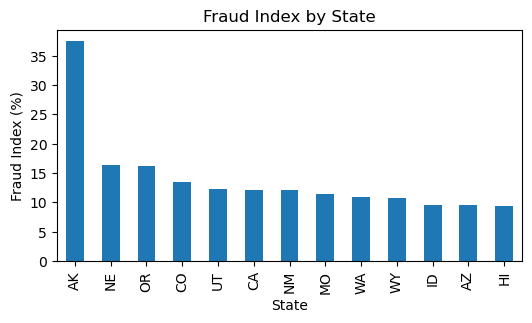

In [6]:
# States
# Step 1: Compute total transactions per state
total_state_tr = df['state'].value_counts()
fraud_state_tr = df[df['is_fraud'] == 1]['state'].value_counts()
fraud_index = (fraud_state_tr / total_state_tr) * 100

fraud_index.sort_values(ascending=False).plot(kind='bar', figsize=(6, 3))
plt.ylabel('Fraud Index (%)')
plt.xlabel('State')
plt.title('Fraud Index by State')
plt.show()


**Fraud by Age**

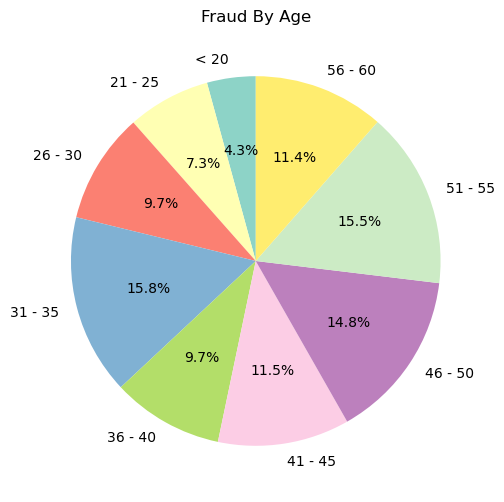

In [7]:
age_brackets = ['< 20',
                '21 - 25', '26 - 30',
                '31 - 35', '36 - 40',
                '41 - 45', '46 - 50',
                '51 - 55', '56 - 60']
age_ranges = [(0, 20),
              (21, 25), (26, 30),
              (31, 35), (36, 40),
              (41, 45), (46, 50),
              (51, 55), (56, 60)]

age_bracket_counts = {}
for bracket, (low, high) in zip(age_brackets, age_ranges):
    age_bracket_counts[bracket] = ((df_fraud['age'] >= low) & (df_fraud['age'] <= high)).sum()

age_fraud_percentage = {
    'Age Bracket': age_bracket_counts.keys(),
    'Percentage': [(count / fraud_count) * 100 for count in age_bracket_counts.values()]
}

age_percentage_df = pd.DataFrame(age_fraud_percentage)

# Plot pie chart
plt.figure(figsize=(8, 6))
age_percentage_df.set_index('Age Bracket')['Percentage'].plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='Set3')
plt.ylabel('')
plt.title('Fraud By Age')
plt.show()

What does this tell us? Maybe ML model tageting age will not be useful since the distribution is pretty even.

**Fraud by Category**

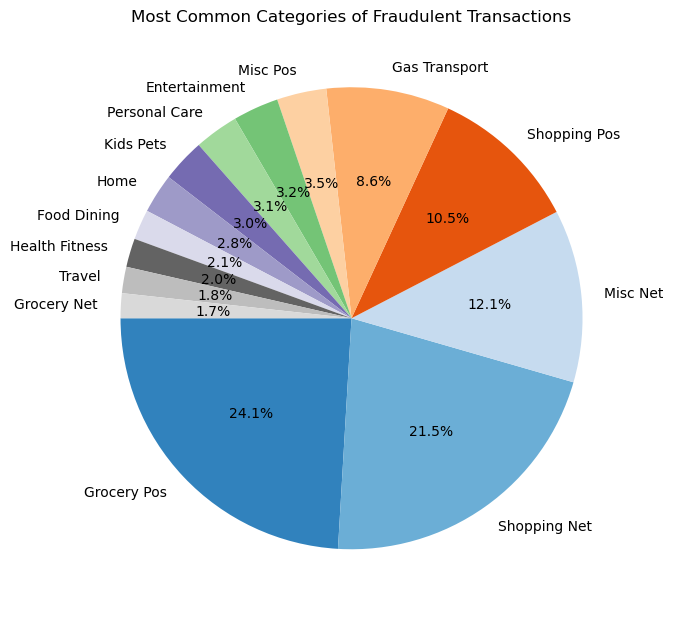

In [8]:
category_counts = df_fraud['category'].value_counts(normalize=True) * 100

# Apply mapping to rename labels
category_counts = category_counts.rename(index=label_map)

plt.figure(figsize=(10, 7.5))
category_counts.plot(kind='pie', autopct='%1.1f%%', startangle=180, colormap='tab20c')
plt.ylabel('')  # Hide y-axis label
plt.title('Most Common Categories of Fraudulent Transactions')
plt.show()

These are more diverse results. Surely we can do something with this.

Histograms:

In [9]:
# Ethan

Maps:

In [10]:
# Cinzia

Lists:

Index(['trans_date_trans_time', 'merchant', 'category', 'amt', 'city', 'state',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'merch_lat',
       'merch_long', 'is_fraud', 'hour'],
      dtype='object')


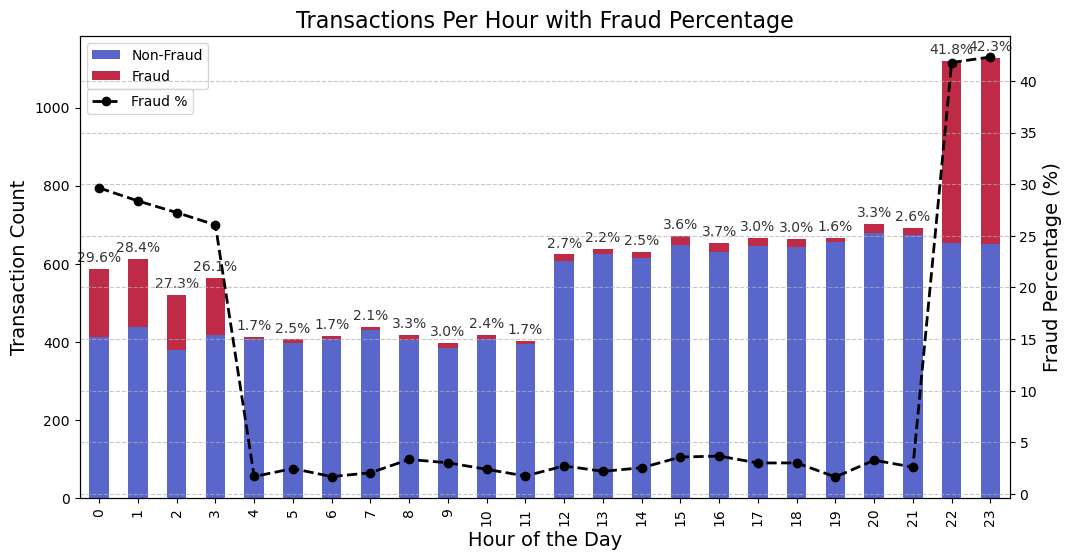

In [44]:
# Maddie
df_time = pd.read_csv("fraud_data.csv", parse_dates=["trans_date_trans_time"])

df_time["trans_date_trans_time"] = pd.to_datetime(df_time["trans_date_trans_time"], format="%d-%m-%Y %H:%M")
df_time["hour"] = df_time["trans_date_trans_time"].dt.hour
print(df_time.columns)
hourly_data = df_time.groupby(["hour", "is_fraud"]).size().unstack(fill_value=0)
hourly_data.columns = ["Non-Fraud", "Fraud"]
hourly_data["Fraud %"] = (hourly_data["Fraud"] / (hourly_data["Non-Fraud"] + hourly_data["Fraud"])) * 100

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot stacked bars
# Stacked bar chart
bars = hourly_data[["Non-Fraud", "Fraud"]].plot(
    kind="bar",
    stacked=True,
    colormap="coolwarm",
    alpha=0.85,
    ax=ax1
)

# Create a second Y-axis for fraud percentage
ax2 = ax1.twinx()
ax2.plot(hourly_data.index, hourly_data["Fraud %"], marker="o", color="black", linestyle="dashed", linewidth=2, label="Fraud %")

# Add fraud percentage labels on top of each bar
for i, (index, row) in enumerate(hourly_data.iterrows()):
    total = row["Non-Fraud"] + row["Fraud"]
    fraud_pct = row["Fraud %"]
    if total > 0:  # Avoid division by zero
        ax1.annotate(f"{fraud_pct:.1f}%", 
                     xy=(i, total),  # Position at top of the stacked bars
                     xytext=(0, 5),  # Offset slightly above
                     textcoords="offset points",
                     ha="center", fontsize=10, color="#333")

# Labels and title
ax1.set_xlabel("Hour of the Day", fontsize=14)
ax1.set_ylabel("Transaction Count", fontsize=14)
ax2.set_ylabel("Fraud Percentage (%)", fontsize=14)
ax1.set_title("Transactions Per Hour with Fraud Percentage", fontsize=16)
ax1.set_xticks(range(24))
ax1.legend(loc="upper left")
ax2.legend(loc="upper left", bbox_to_anchor=(0, .9))  # Position fraud percentage legend below

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

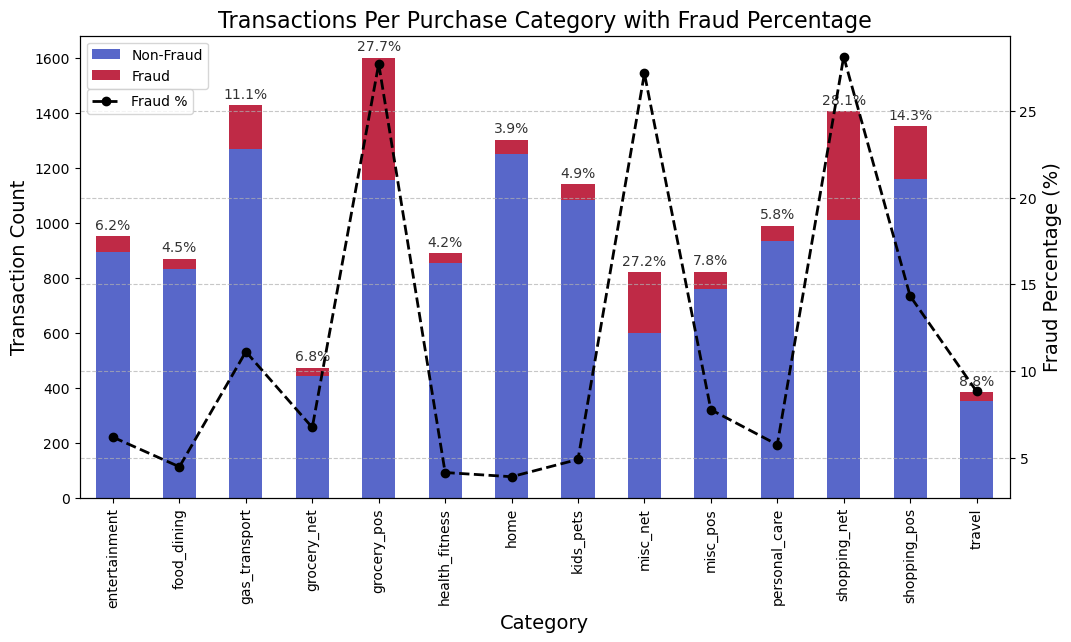

In [48]:
categorical_data = df_time.groupby(['category', 'is_fraud']).size().unstack(fill_value=0)
categorical_data.columns = ['Non-Fraud', 'Fraud']
categorical_data['Fraud %'] = (categorical_data['Fraud'] / (categorical_data['Non-Fraud'] + categorical_data['Fraud'])) * 100

fig1, ax3 = plt.subplots(figsize=(12, 6))

# Plot stacked bars
# Stacked bar chart
bars = categorical_data[["Non-Fraud", "Fraud"]].plot(
    kind="bar",
    stacked=True,
    colormap="coolwarm",
    alpha=0.85,
    ax=ax3
)

# Create a second Y-axis for fraud percentage
ax4 = ax3.twinx()
ax4.plot(categorical_data.index, categorical_data["Fraud %"], marker="o", color="black", linestyle="dashed", linewidth=2, label="Fraud %")

# Add fraud percentage labels on top of each bar
for i, (index, row) in enumerate(categorical_data.iterrows()):
    total = row["Non-Fraud"] + row["Fraud"]
    fraud_pct = row["Fraud %"]
    if total > 0:  # Avoid division by zero
        ax3.annotate(f"{fraud_pct:.1f}%", 
                     xy=(i, total),  # Position at top of the stacked bars
                     xytext=(0, 5),  # Offset slightly above
                     textcoords="offset points",
                     ha="center", fontsize=10, color="#333")

# Labels and title
ax3.set_xlabel("Category", fontsize=14)
ax3.set_ylabel("Transaction Count", fontsize=14)
ax4.set_ylabel("Fraud Percentage (%)", fontsize=14)
ax3.set_title("Transactions Per Purchase Category with Fraud Percentage", fontsize=16)
ax3.set_xticks(range(len(categorical_data)))
ax3.legend(loc="upper left")
ax4.legend(loc="upper left", bbox_to_anchor=(0, .9))  # Position fraud percentage legend below

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### Machine Learning :(

In [12]:
# code